# Comparative analysis on spatial multi-omics data of mouse brain with Parkinson's disease

In this tutorial, we perform a comparative analysis of spatial multi-omics data from the mouse brain with Parkinson’s disease, where the left and right hemispheres represent the intact and lesioned conditions, respectively. This comparison allows us to investigate how MCC differs between diseased and healthy regions.

In [ ]:
# Importing packages
import os
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Setting your work dictionary
os.chdir("/home/project/metachat_packages/")

In [3]:
import sys
sys.path.append("/home/project/metachat_packages/MetaChat-main/")
import metachat_new as mc

## Import MetaChat results 

We manually annotated the MetaChat result using Napari, dividing the left hemisphere as "Intact" and the right hemisphere as "Lesion". For convenience, we will directly import the annotated h5ad.

In [4]:
adata = sc.read('datasets/mouse_brain_parkinson/metachat_result_divided.h5ad')

The annotations are stored in adata.obs['lesion_shapes'], which can be visualized for further comparison.

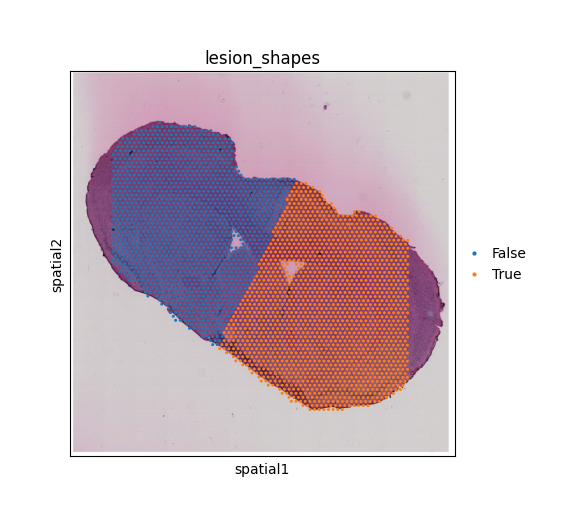

In [5]:
fig, ax = plt.subplots(figsize = (6,5))
sq.pl.spatial_scatter(adata,
                      color = 'lesion_shapes',
                      ax = ax)
ax.set_box_aspect(1)

## Clustering through MCC signals

We performed clustering based on MCC signals to investigate whether these communication activities show spatially organized or region-specific distributions within the tissue. 

Therefore, we constructed a new `adata` object in which the features represent only MCC-related signals — including the total sender and receiver activities for each cell (spot).

In [6]:
MCC_matrix_sender = adata.obsm['MetaChat-MetaChatDB-sum-sender'].iloc[:,:-1]
MCC_matrix_receiver = adata.obsm['MetaChat-MetaChatDB-sum-receiver'].iloc[:,:-1]
MCC_matrix = pd.concat([MCC_matrix_sender, MCC_matrix_receiver], axis=1)
adata_MCC = sc.AnnData(MCC_matrix)
adata_MCC.uns['spatial'] = adata.uns['spatial']
adata_MCC.obsm['spatial'] = adata.obsm['spatial']

In [7]:
adata_MCC

AnnData object with n_obs × n_vars = 3054 × 1034
    uns: 'spatial'
    obsm: 'spatial'

We next computed the spatial neighborhood graph and assessed the spatial autocorrelation of each MCC feature using Moran’s I statistic.
This analysis aims to evaluate whether MCC signals display spatial dependency — that is, whether cells with similar levels of metabolite-mediated communication tend to cluster together in the tissue.
Identifying spatially autocorrelated MCC features helps reveal region-specific communication patterns and highlights spatial domains with coordinated metabolic activity.

In [8]:
sq.gr.spatial_neighbors(adata_MCC)
sq.gr.spatial_autocorr(
    adata_MCC,
    mode = "moran",
    n_perms = 100,
    n_jobs = 1,
)

/opt/conda/envs/metachat_test_20251015/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 100/100 [00:03<00:00, 31.50/s]


In [10]:
adata_MCC.var_names_make_unique()
moranI = adata_MCC.uns["moranI"]
adata_MCC_cluster = adata_MCC[:, moranI.index[:200]].copy()

Similar to scRNA-seq analysis, we performed dimensionality reduction and clustering on the MCC-derived features to identify spatial domains with distinct metabolic communication profiles.

In [ ]:
random_seed = 20
sc.pp.highly_variable_genes(adata_MCC_cluster, min_mean=0.0125, min_disp=0.2)
adata_MCC_cluster = adata_MCC_cluster[:, adata_MCC_cluster.var.highly_variable]
sc.tl.pca(adata_MCC_cluster, svd_solver='arpack', random_state=random_seed)
sc.pp.neighbors(adata_MCC_cluster, n_neighbors=10, n_pcs=40, random_state=random_seed)
sc.tl.umap(adata_MCC_cluster, random_state=random_seed)
sc.tl.leiden(adata_MCC_cluster, resolution=0.25, random_state=random_seed)

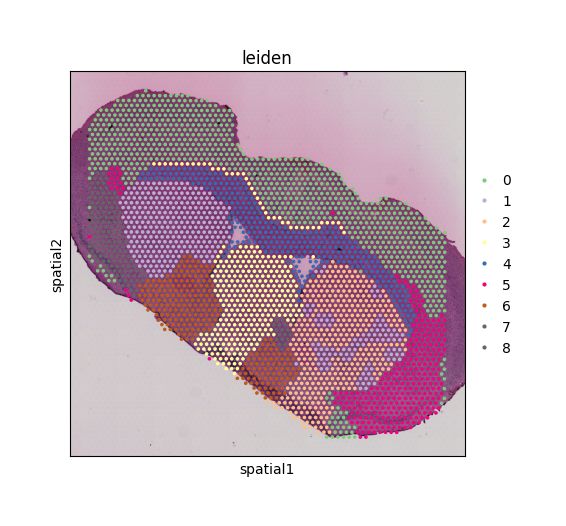

In [ ]:
fig, ax = plt.subplots(figsize = (6,5))
sc.pl.spatial(adata_MCC_cluster, color='leiden', palette='Accent', ax=ax)
ax.set_box_aspect(1)

Using MCC-derived features, distinct anatomical regions can still be clearly delineated, demonstrating that metabolic communication patterns reflect the underlying tissue organization.
Interestingly, the area originally clustered as the Striatum dorsal region based on gene expression is now divided into two subgroups when clustered by MCC signals, suggesting notable differences in metabolic communication between the intact and lesioned hemispheres.
In the following section, we perform differential analysis to further characterize these MCC differences.

## Differential MCC among each tissue type

In this step, we perform differential analysis of MCC features across tissue types to detect metabolites and sensors exhibiting significant differences in communication activity, thereby revealing region-specific metabolic communication patterns.

In [14]:
adata_MCC.var_names_make_unique()
moranI = adata_MCC.uns["moranI"]
adata_MCC_key = adata_MCC[:, moranI['pval_norm'] < 0.05].copy()
adata_MCC_key.obs['tissue_type'] = adata.obs['tissue_type'].copy()

In [15]:
sc.tl.rank_genes_groups(adata_MCC_key, groupby="tissue_type", method="t-test_overestim_var")
DEG_result = sc.get.rank_genes_groups_df(adata_MCC_key, group=None, pval_cutoff=0.05, log2fc_min=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


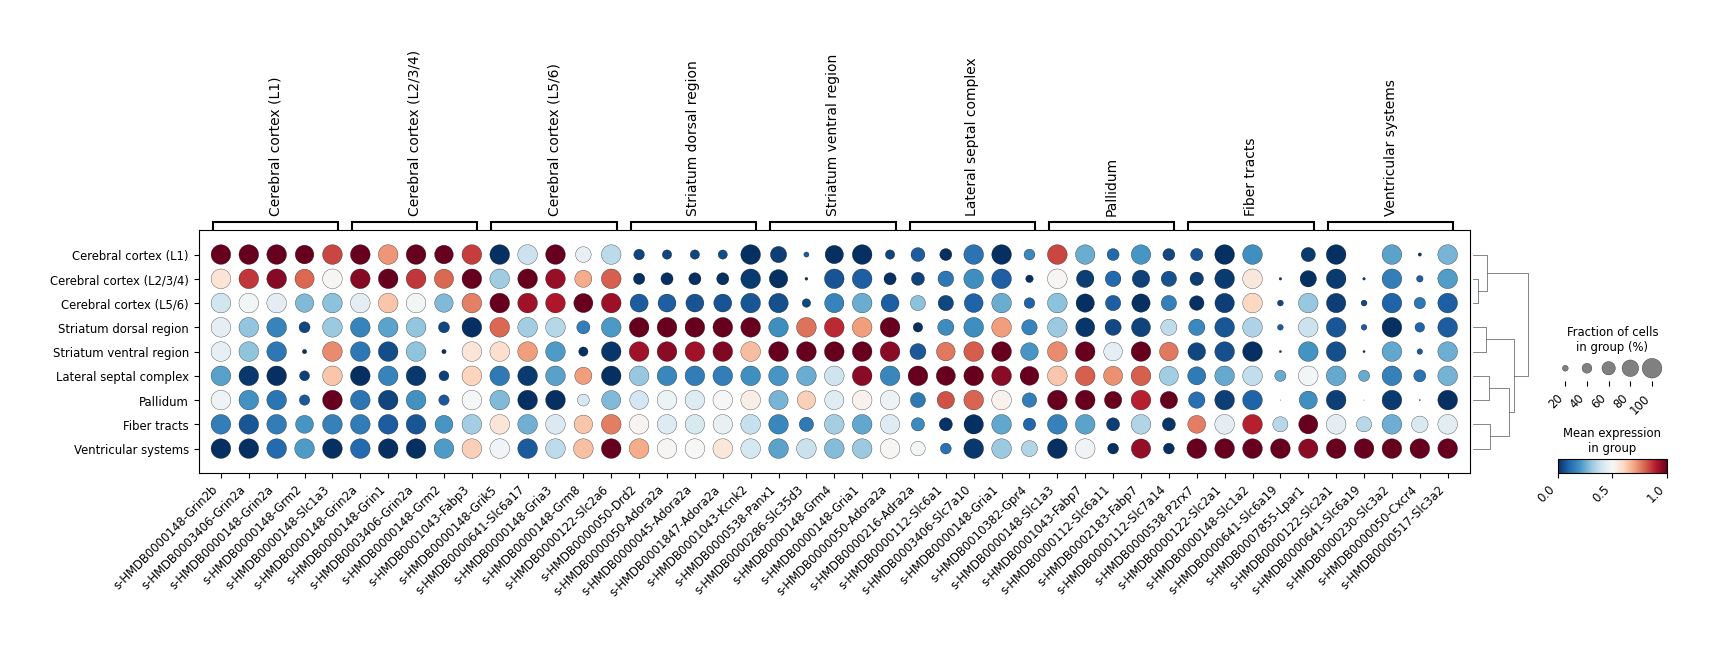

In [16]:
dp = sc.pl.rank_genes_groups_dotplot(
    adata_MCC_key,
    n_genes=5,
    standard_scale='var',
    cmap='RdBu_r',
    swap_axes=False,
    show=False
)

for ax in plt.gcf().axes:
    ax.tick_params(axis='x', labelrotation=45)
    for tick in ax.get_xticklabels():
        tick.set_horizontalalignment('right')

## Differential MCC between intact and lesion region

To focus on the most spatially structured communication features, we selected the top 100 sender-related and top 100 receiver-related MCC signals with the highest Moran’s I scores.
These features represent metabolite–sensor activities that exhibit the strongest spatial autocorrelation, suggesting they are likely to be biologically organized rather than random.
The selected features were then combined for downstream differential analysis between the Intact and Lesion hemispheres.

In [21]:
adata_MCC_sender = sc.AnnData(MCC_matrix_sender)
adata_MCC_sender.uns['spatial'] = adata.uns['spatial']
adata_MCC_sender.obsm['spatial'] = adata.obsm['spatial']

In [22]:
sq.gr.spatial_neighbors(adata_MCC_sender)
sq.gr.spatial_autocorr(
    adata_MCC_sender,
    mode = "moran",
    n_perms = 100,
    n_jobs = 1,
)

  0%|          | 0/100 [00:00<?, ?/s]

100%|██████████| 100/100 [00:02<00:00, 36.74/s]


In [23]:
adata_MCC_receiver = sc.AnnData(MCC_matrix_receiver)
adata_MCC_receiver.uns['spatial'] = adata.uns['spatial']
adata_MCC_receiver.obsm['spatial'] = adata.obsm['spatial']

In [24]:
sq.gr.spatial_neighbors(adata_MCC_receiver)
sq.gr.spatial_autocorr(
    adata_MCC_receiver,
    mode = "moran",
    n_perms = 100,
    n_jobs = 1,
)

  0%|          | 0/100 [00:00<?, ?/s]

100%|██████████| 100/100 [00:02<00:00, 37.93/s]


In [32]:
adata_MCC.var_names_make_unique()
selected_vars = adata_MCC_sender.uns["moranI"].index[:100].union(
    adata_MCC_receiver.uns["moranI"].index[:100]
)
adata_MCC_diff = adata_MCC[:, selected_vars].copy()

In [33]:
adata_MCC_diff

AnnData object with n_obs × n_vars = 3054 × 200
    uns: 'spatial', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [34]:
adata_MCC_diff.obs['lesion_shapes'] = adata.obs['lesion_shapes'].copy()
adata_MCC_diff.uns['lesion_shapes_colors'] = adata.uns['lesion_shapes_colors'].copy()
adata_MCC_diff.obs['tissue_type'] = adata.obs['tissue_type'].copy()

In [35]:
adata_MCC_diff.obs['disease_group'] = 0
adata_MCC_diff.obs.loc[adata_MCC_diff.obs['lesion_shapes'] == False, 'disease_group'] = 'Intact'
adata_MCC_diff.obs.loc[adata_MCC_diff.obs['lesion_shapes'] == True, 'disease_group'] = 'Lesion'

/tmp/ipykernel_3734810/1412599778.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Intact' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata_MCC_diff.obs.loc[adata_MCC_diff.obs['lesion_shapes'] == False, 'disease_group'] = 'Intact'


In [36]:
sc.tl.rank_genes_groups(adata_MCC_diff, groupby="disease_group", method="t-test_overestim_var")
DEG_result = sc.get.rank_genes_groups_df(adata_MCC_diff, group="Intact")

We then visualized the differential MCC features using a volcano plot, which highlights metabolite–sensor pairs with significant differences in communication strength between the Intact and Lesion hemispheres.

<Axes: title={'center': 'Volcano Plot'}, xlabel='Log2 Fold Change', ylabel='-Log10 p-value'>

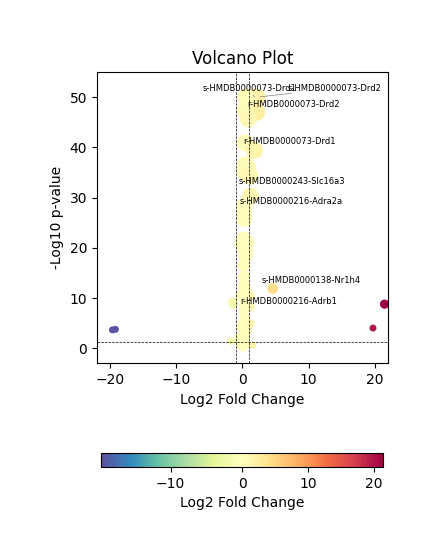

In [38]:
mc.pl.plot_DEG_volcano(DEG_result)

Since a few metabolite–sensor pairs showed abnormally large fold changes, likely due to low expression levels or sparse spot coverage, we restricted the analysis to pairs with |log₂ fold change| < 4 to avoid artifacts and focus on biologically meaningful differences.

In [39]:
DEG_result_filtered = DEG_result.loc[abs(DEG_result['logfoldchanges'])<=4,:]

0 [-0.67501402  0.42160331]
1 [-0.40538805 -0.16830784]


<Axes: title={'center': 'Volcano Plot'}, xlabel='Log2 Fold Change', ylabel='-Log10 p-value'>

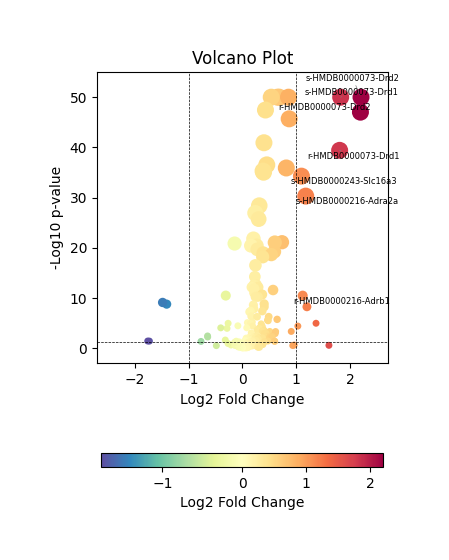

In [40]:
mc.pl.plot_DEG_volcano(DEG_result_filtered,
                       neglog10_cap = 50)

We observed that dopamine (HMDB0000073) and norepinephrine (HMDB0000216) exhibited significant differences in MCC activity between the intact and lesioned hemispheres, which is consistent with previous reports on their roles in Parkinson’s disease.
In the following section, we perform further analyses focusing on MCCs associated with these two metabolites.

## Differential group-level MCC between intact and lesion region among each tissue type

To further investigate how Parkinson’s disease affects MCC, we next examined the group-level MCC patterns associated with dopamine (HMDB0000073) and norepinephrine (HMDB0000216).
Specifically, we aimed to determine which tissue regions act as key senders or receivers of these signals, and how these communication relationships differ between the intact and lesion hemispheres.
This comparison provides insights into how dopaminergic and noradrenergic signaling networks are reorganized under pathological conditions.

Split adata into intact and lesion subsets

In [41]:
adata_intact = adata[adata.obs['lesion_shapes'] == False,:]
adata_lesion = adata[adata.obs['lesion_shapes'] == True,:]

The original output of MetaChat provides MCC signals for each individual metabolite–sensor pair.
Here, we use `mc.tl.summary_communication` to summarize the overall MCC activity associated with specific metabolites (e.g., dopamine and norepinephrine), aggregating their communication strengths across all corresponding sensors.

In [43]:
sum_metabolites = ['HMDB0000216', 'HMDB0000073']
mc.tl.summary_communication(adata = adata_intact,
                            database_name = 'MetaChatDB',
                            sum_metabolites = sum_metabolites)
mc.tl.summary_communication(adata = adata_lesion,
                            database_name = 'MetaChatDB',
                            sum_metabolites = sum_metabolites)

The function mc.tl.communication_group_spatial performs group-level MCC analysis by incorporating spatial permutation testing to evaluate whether a given signal shows significant interactions between different tissue types.
It outputs corresponding p-values that reflect the statistical significance of these spatial communication relationships.

In [44]:
mc.tl.communication_group_spatial(adata = adata_intact,
                                  database_name = 'MetaChatDB',
                                  group_name = "tissue_type",
                                  sum_metabolites = sum_metabolites,
                                  n_permutations = 100)
mc.tl.communication_group_spatial(adata = adata_lesion,
                                  database_name = 'MetaChatDB',
                                  group_name = "tissue_type",
                                  sum_metabolites = sum_metabolites,
                                  n_permutations = 100)

  Computing group-level MCC: 100%|██████████| 8100/8100 [00:34<00:00, 233.94it/s]


<Axes: >

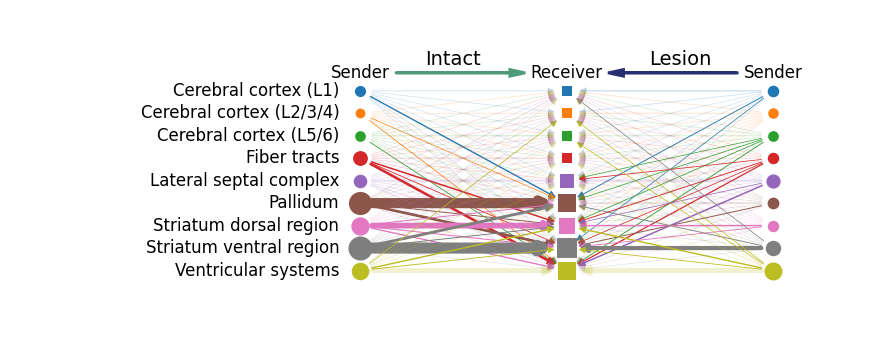

In [48]:
mc.pl.plot_group_communication_compare_hierarchy_diagram(adata_A = adata_intact,
                                                         adata_B = adata_lesion,
                                                         condition_name_A = "Intact",
                                                         condition_name_B = "Lesion",
                                                         database_name = 'MetaChatDB',
                                                         group_name = 'tissue_type',
                                                         metabolite_name = "HMDB0000073",
                                                         permutation_spatial = True,
                                                         p_value_cutoff = 0.05,
                                                         node_sizes_limit = (50,300),
                                                         edge_sizes_limit = (0.5,8),
                                                         group_cmap = None,
                                                         alpha = 0.2,
                                                         figsize = (10, 3))

<Axes: >

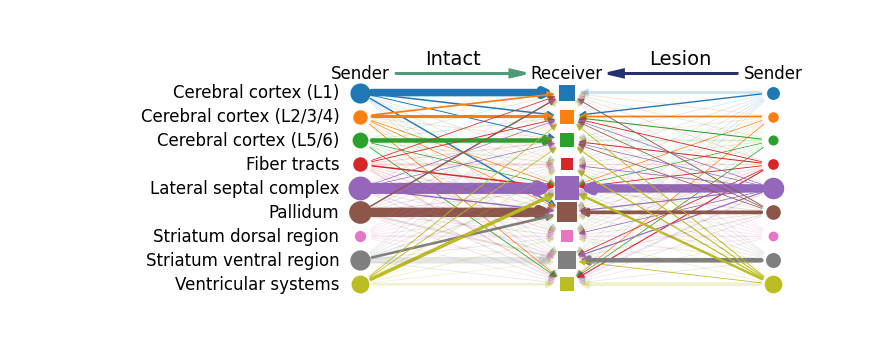

In [49]:
mc.pl.plot_group_communication_compare_hierarchy_diagram(adata_A = adata_intact,
                                                         adata_B = adata_lesion,
                                                         condition_name_A = "Intact",
                                                         condition_name_B = "Lesion",
                                                         database_name = 'MetaChatDB',
                                                         group_name = 'tissue_type',
                                                         metabolite_name = "HMDB0000216",
                                                         permutation_spatial = True,
                                                         p_value_cutoff = 0.05,
                                                         node_sizes_limit = (50,300),
                                                         edge_sizes_limit = (0.5,8),
                                                         group_cmap = None,
                                                         alpha = 0.2,
                                                         figsize = (10, 3.2))